## Libraries

In [212]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import kagglehub
import timm
from tqdm.notebook import tqdm # for progress bars

import numpy as np
import pandas as pd
from glob import glob
import sys
import time
import matplotlib.pyplot as plt
import cv2

### Version Checks

In [213]:
print('Sytem Verison:', sys.version)
print('PyTorch Version:', torch.__version__)
print('CUDA Version:', torch.version.cuda)
print('Torchvision Version:', torchvision.__version__)
print('Numpy Version:', np.__version__)
print('Pandas Version:', pd.__version__)

Sytem Verison: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:53:32) [GCC 12.3.0]
PyTorch Version: 2.2.1
CUDA Version: 11.8
Torchvision Version: 0.17.1
Numpy Version: 1.26.4
Pandas Version: 2.2.2


## Data Handling

### Organizing and Initializing

In [214]:
class Datadex(Dataset): # loads data
    def __init__(self, data_dir, transform=None): # initializes data from data_dir, all data is tranformed to the same size
        self.data = ImageFolder(data_dir, transform=transform) # loads image data, handles labelling of subfolders as well

    def __len__(self): # takes the length of the data, data loader needs to know how many examples we have
        return len(self.data)
    
    def __getitem__(self, idx): # tracks the index of each data item and returns one at a time
        return self.data[idx]
    
    @property # decorates the following function with by passing it through 'property()' 
    def classes(self):
        return self.data.classes # returns the classes from the ImageFolder

In [215]:
# path = kagglehub.dataset_download("jehanbhathena/weather-dataset") # test weather dataset
data_dir='/home/unitx/wabbit_playground/nn/split_weather_dataset/train'
dataset = Datadex(data_dir)
print(dataset.classes)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [216]:
# Each image is labeled and each label corresponds to a number. Pytorch uses these numbers to learn and label future images. We can view the labels/numbers here
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'dew', 1: 'fogsmog', 2: 'frost', 3: 'glaze', 4: 'hail', 5: 'lightning', 6: 'rain', 7: 'rainbow', 8: 'rime', 9: 'sandstorm', 10: 'snow'}


In [217]:
# need to transform the images so that they are all the same size (128,128)
# note that the data set is iterable, the Shape has three metrics (3, 128, 128) for (RBG channels, length, width)
transform = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor(),])

train_folder = '/home/unitx/wabbit_playground/nn/split_weather_dataset/train/'
validate_folder = '/home/unitx/wabbit_playground/nn/split_weather_dataset/val/'
test_folder = '/home/unitx/wabbit_playground/nn/split_weather_dataset/test/'

train_dataset = Datadex(train_folder, transform) # transform data
val_dataset = Datadex(validate_folder, transform) # transform data
test_dataset = Datadex(test_folder, transform) # transform data



### Dataloader

In [218]:
# using a pytorch dataloader streamlines the training process
# note that the dataloader is also iterable, but the Shape has an extra argument (batch_size) bc the dataset is batched
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True) # sets the batch size that is pulled from the datasets each iteration and turns shuffle on to randomize pulls, more arguments available to explore
val_loader =  DataLoader(val_dataset, batch_size=50, shuffle=False)
test_loader =  DataLoader(test_dataset, batch_size=50, shuffle=False)

In [247]:
# notice that each time you run this code block, the labels change because the selected images are randomized (shuffled)
for images, labels in train_loader:
    break
labels

tensor([ 3,  2,  8,  9,  1, 10,  1,  9, 10,  9,  8, 10, 10,  0,  3,  3,  0,  5,
         8,  0,  2,  4,  9,  2, 10,  0,  3,  0,  1,  0,  1,  6, 10, 10,  5,  1,
         0,  8,  1,  5,  9,  8,  8,  8, 10,  0,  9,  1,  1,  0])

## Building the Model

##### PyTorch models are extremely configurable and this is something to explore. For the purposes of this first exploration, the configurations will be simple
- the model can be created from scratch, defining each layer
- architecturs like ```timm``` are already available for image classification
- it's extremely important to understand the shape of the data at each layer, it's most important to modify the final layer

In [ ]:
class WeatherReporter(nn.Module):
    # this is where we define all the parts of the model
    def __init__(self, num_classes): # number of labels/classes
        super(WeatherReporter, self).__init__() # intializes the object with everything from the parent class
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True) #this is a popular small model used for image classification, pretrained means the weights have already been set and pretrained on
        self.features = nn.Sequential(*list(self.base_model.children())[:-1]) #remove the last layer of the pretrained model bc we'll strcuture ours differently
        # freeze the base model layers for faster training, these deep pretrained layers are helpful for kickstarting this model  
        for param in self.features.parameters():
            param.requires_grad = False
            
        enet_out_size = 1280 # this model has a default output size of 1280, we need to reclassify it to the number of classes in our dataset (11)
        self.classifier = nn.Sequential(nn.Flatten(),nn.Linear(enet_out_size, num_classes))

    # connects all defined parts to process a batch and returns output
    def forward(self, x): # x is the batch input
        x = self.features(x) # we are calling our features defintion on our input
        output = self.classifier(x) # we then call the classifer on our features
        return output #return output (last layer)


In [250]:
model = WeatherReporter(num_classes=11)
model

WeatherReporter(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_

In [251]:
# check to see if model can accept data input and has the correct shape
ex = model(images)
ex.shape # [batch_size, num_classes]

torch.Size([50, 11])

## The Training Loop

##### Now we will train the model on data
- it is important to have use a validation set that the model has never seen before to confirm that it is working properly; this can be done easily by creating two datasets with our existing class
- we will also calculate loss and backpropogation; this can be done with packages, though we will write out the code to get a feel for the process
- we will use an optimizer and a loss function

Epoch: one run through the entire training dataset

Step: one batch of data as defined in our dataloader

In [252]:
# Loss function
# this allows us to measure how well the model is performing; it is often measured aainst ground truth or true target values
# a well-performing model minimizes the loss function
# Cross Entropy Loss a popular loss function that penalizes a model for confident wrong class predictions,
# can be appriximated as Loss = -log(y_hat) where y_hat is the probability of the predicted class.
# Cross Entropy Loss suffers when there is a class imbalance, when one class or more classes is significantly more likely than others; in this case, weighted loss is recommended

# the gradient of a loss function is a vector of partial derivatives that measures loss wrt each weight and parameter. it's literally a gradient taken of the loss function

criterion = nn.CrossEntropyLoss()

# Optimizer
# this architecture helps us minimize loss and can adjust weights on the model to do so
# using the gradient of the loss function, which is calculated with the backpropogation algorithm, the optimizer adjust parameters to minimize loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # we provide the optimizer with our model parameters and specifiy and learning rate; this can be adjusted throughout trainin but is constant for now

In [253]:
# let's test it, loss wil be high before training
criterion(ex, labels)

tensor(2.4183, grad_fn=<NllLossBackward0>)

In [ ]:
# specify training parameters

num_epochs = 20
train_losses, val_losses = [], []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = WeatherReporter(num_classes=11)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, weight_decay=1e-4) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=2)


for epoch in range(num_epochs):
    model.train() # set model to train
    running_loss = 0.0 # initialise loss
    # for images, labels in tqdm(train_loader, desc='Training Loop'):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # move to device
        optimizer.zero_grad() # initialize optimizer
        outputs = model(images) # run images through model
        # print(outputs.size)
        loss = criterion(outputs, labels) # calculate loss from outputs
        loss.backward() # runs backpropogation on loss
        optimizer.step() # run optimizer
        running_loss += loss.item() * labels.size(0)
    # one epoch has run
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # validation phase
    model.eval() # set model to evaluation/validation
    running_loss = 0.0 # initialize loss for validation
    with torch.no_grad(): # prevents weights from being touched during this phase
        # for images, labels in tqdm(val_loader, desc='Validation Loop'):
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) # move to device
            outputs = model(images) # run images through model
            loss = criterion(outputs, labels) # calculate loss from outputs
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    scheduler.step(val_loss) # adjust learning rate if necessary

    # Epoch Stats
    print(f'Epoch: {epoch+1}/{num_epochs} - Train Loss: {train_loss}, Validation Loss: {val_loss}')


Using device: cuda
Epoch: 1/10 - Train Loss: 1.5230118853364458, Validation Loss: 1.0582704723286005
Epoch: 2/10 - Train Loss: 0.8686294396370432, Validation Loss: 0.8124478080108487
Epoch: 3/10 - Train Loss: 0.6980325015157318, Validation Loss: 0.7294314601372793
Epoch: 4/10 - Train Loss: 0.6247425955957687, Validation Loss: 0.6769872233199333
Epoch: 5/10 - Train Loss: 0.5615922145192912, Validation Loss: 0.6482032397554177
Epoch: 6/10 - Train Loss: 0.5293442018831773, Validation Loss: 0.6412888018398119
Epoch: 7/10 - Train Loss: 0.48924262849942135, Validation Loss: 0.6192157396867828
Epoch: 8/10 - Train Loss: 0.46102283991001936, Validation Loss: 0.6090628594362424
Epoch: 9/10 - Train Loss: 0.4384505464828385, Validation Loss: 0.6022516161232291
Epoch: 10/10 - Train Loss: 0.42877763671901836, Validation Loss: 0.5907024610516635


In [310]:
last_val_losses = val_losses
last_train_losses = train_losses

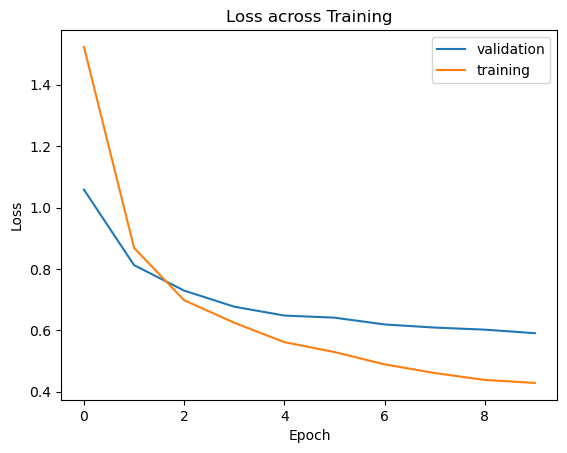

In [327]:
plt.plot(np.arange(num_epochs),val_losses, label='validation')
plt.plot(np.arange(num_epochs),train_losses, label='training')
# plt.plot(np.arange(num_epochs),last_val_losses, label='previous validation', linestyle='--')
# plt.plot(np.arange(num_epochs),last_train_losses, label='previous training', linestyle='--')
plt.title('Loss across Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.xlim(1,7)
# plt.ylim(0,4)
plt.legend()
plt.show()

## Evaluating the Results

##### Let's see if it worked
- load and preprocess test images
- make predictions from test images

In [261]:
# def preprocess(path, transform):
#     image = Image.open(path).convert('RGB')
#     return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim = 1) # softmax is like a sigmoid but used for multiclass classification
    return probabilities.cpu().numpy().flatten()

In [318]:

# count = 0
import random
N = random.randint(0, 9)
N2 = random.randint(1, 33)
# print(N)
# print(N2)
i = 0
for test_images, test_labels in test_loader:
    if i == N2:
        break
    else:   # load random image from test_set
        sample_label = test_labels[N]
        sample_image = test_images[N]
    i += 1

    print(sample_label)
    # print(sample_image)

class_no = sample_label.item()
the_classes = dataset.classes

sample_array = sample_image.cpu().numpy()
sample = np.transpose(sample_array, (1, 2, 0))

probabilities = predict(model, sample_image.unsqueeze(0), device)


tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(2)
tensor(2)
tensor(3)
tensor(4)
tensor(4)
tensor(5)
tensor(6)
tensor(6)
tensor(7)
tensor(8)
tensor(8)


Text(0.5, 1.0, 'predicted label: rime')

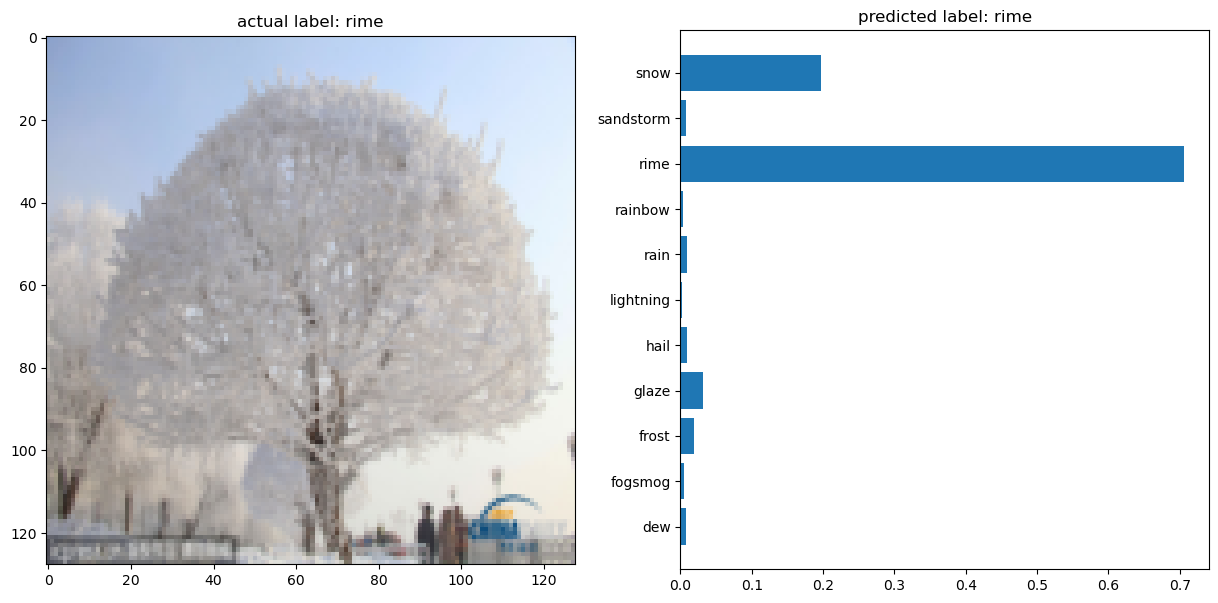

In [319]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
prediction = the_classes[np.argmax(probabilities)]

ax[0].imshow(sample)
ax[0].set_title(f'actual label: {the_classes[class_no]}')

ax[1].barh(the_classes, probabilities)
ax[1].set_title(f'predicted label: {prediction}')